Import library

In [73]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate


Fetch Stock Data

In [74]:
data = yf.download("IRCTC.NS",period="1y", interval="1d")
print(data)
data.to_csv("IRCTC.csv")

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-21  643.400024  652.000000  640.400024  650.500000  648.107239   
2023-08-22  651.099976  656.500000  647.250000  651.700012  649.302795   
2023-08-23  653.000000  659.599976  648.549988  649.650024  647.260376   
2023-08-24  652.049988  664.500000  652.000000  659.599976  657.173706   
2023-08-25  660.400024  670.000000  651.000000  658.250000  655.828735   
...                ...         ...         ...         ...         ...   
2024-08-12  926.450012  933.250000  915.049988  924.400024  924.400024   
2024-08-13  929.750000  931.450012  911.299988  918.450012  918.450012   
2024-08-14  928.000000  929.000000  906.299988  909.849976  909.849976   
2024-08-16  914.900024  925.900024  911.299988  924.750000  924.750000   
2024-08-19  926.000000  940.700012  925.150024  937.700012  937.700012   

             Volume  
Date           

# Calculate moving averages

In [75]:
data['20_SMA'] = data.Close.rolling(window=20, min_periods=1).mean()
data['50_SMA'] = data.Close.rolling(window=50, min_periods=1).mean()

# Generate buy/sell signals

In [76]:
data['Signal'] = 0
data['Signal'] = np.where(data['20_SMA'] > data['50_SMA'], 1, 0)
data['Position'] = data['Signal'].diff()

# Visualize the data

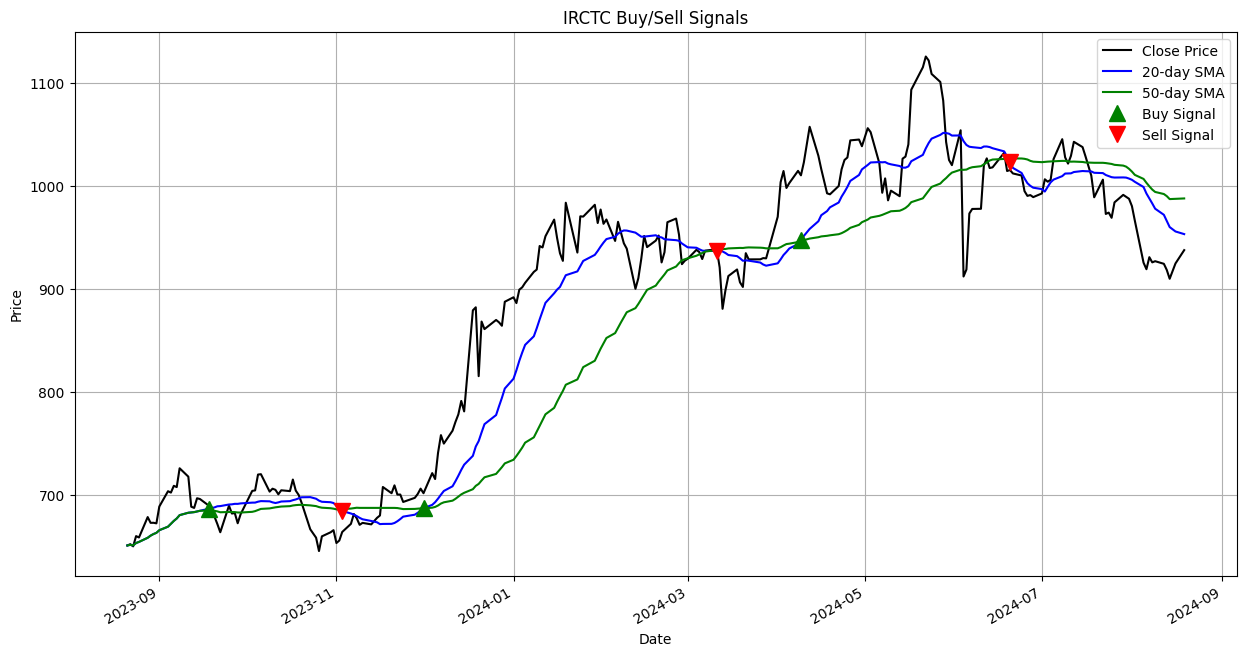

In [78]:
plt.figure(figsize=(15,8))
data['Close'].plot(color='black', label='Close Price')
data['20_SMA'].plot(color='blue', label='20-day SMA')
data['50_SMA'].plot(color='green', label='50-day SMA')
plt.plot(data[data['Position'] == 1].index, data['20_SMA'][data['Position'] == 1], '^', markersize=12, color='g', label='Buy Signal')
plt.plot(data[data['Position'] == -1].index, data['20_SMA'][data['Position'] == -1], 'v', markersize=12, color='r', label='Sell Signal')
plt.title('IRCTC Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Filter the DataFrame to include only Buy and Sell signals

In [79]:
df_pos = data.iloc[-200:][(data.iloc[-200:]['Position'] == 1) | (data.iloc[-200:]['Position'] == -1)].copy()
df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
print(tabulate(df_pos[['Close', 'Position']], headers='keys', tablefmt='psql'))

+---------------------+---------+------------+
| Date                |   Close | Position   |
|---------------------+---------+------------|
| 2023-11-03 00:00:00 |  663.6  | Sell       |
| 2023-12-01 00:00:00 |  701.3  | Buy        |
| 2024-03-11 00:00:00 |  938.6  | Sell       |
| 2024-04-09 00:00:00 | 1010.45 | Buy        |
| 2024-06-20 00:00:00 | 1015.6  | Sell       |
+---------------------+---------+------------+


# Define the Backtest class

In [84]:
class Backtest:
    def __init__(self):
        self.columns = ['Equity Name', 'Trade', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'Quantity', 'Position Size', 'PNL', '% PNL']
        self.backtesting = pd.DataFrame(columns=self.columns)
        self.trade_log = {}  # Initialize an empty trade_log dictionary

    def buy(self, equity_name, entry_time, entry_price, qty):
        self.trade_log = dict(zip(self.columns, [None] * len(self.columns)))  # Initialize trade_log when buying
        self.trade_log['Trade'] = 'Long Open'
        self.trade_log['Quantity'] = qty
        self.trade_log['Position Size'] = round(self.trade_log['Quantity'] * entry_price, 3)
        self.trade_log['Equity Name'] = equity_name
        self.trade_log['Entry Time'] = entry_time
        self.trade_log['Entry Price'] = round(entry_price, 2)

    def sell(self, exit_time, exit_price, exit_type, charge):
        if not self.trade_log:
            print("Error: Attempted to sell without an open position.")
            return
        self.trade_log['Trade'] = 'Long Closed'
        self.trade_log['Exit Time'] = exit_time
        self.trade_log['Exit Price'] = round(exit_price, 2)
        self.trade_log['Exit Type'] = exit_type
        self.trade_log['PNL'] = round((self.trade_log['Exit Price'] - self.trade_log['Entry Price']) * self.trade_log['Quantity'] - charge, 3)
        self.trade_log['% PNL'] = round((self.trade_log['PNL'] / self.trade_log['Position Size']) * 100, 3)
        self.trade_log['Holding Period'] = exit_time - self.trade_log['Entry Time']
        self.backtesting = pd.concat([self.backtesting, pd.DataFrame([self.trade_log])], ignore_index=True)
        self.trade_log = {}  # Reset trade_log after closing the position


# Initialize the backtest

In [85]:
bt = Backtest()
capital = 50000

for index, data_row in df_pos.iterrows():
    if data_row['Position'] == 'Buy':
        qty = capital // data_row['Close']
        bt.buy('IRCTC', index, data_row['Close'], qty)
    else:
        bt.sell(index, data_row['Close'], 'Exit Trigger', 0)

# Print backtest results
print(bt.backtesting)

# Save the backtesting results to a CSV file
bt.backtesting.to_csv('IRCTC_TEST.csv')

Error: Attempted to sell without an open position.
  Equity Name        Trade Entry Time  Entry Price  Exit Time  Exit Price  \
0       IRCTC  Long Closed 2023-12-01       701.30 2024-03-11       938.6   
1       IRCTC  Long Closed 2024-04-09      1010.45 2024-06-20      1015.6   

   Quantity  Position Size       PNL   % PNL     Exit Type Holding Period  
0      71.0      49792.299  16848.30  33.837  Exit Trigger       101 days  
1      49.0      49512.051    252.35   0.510  Exit Trigger        72 days  


C:\Users\ANIKET LIGAM\AppData\Local\Temp\ipykernel_20260\1950588908.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.backtesting = pd.concat([self.backtesting, pd.DataFrame([self.trade_log])], ignore_index=True)
